#### Instructions

It's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.

The experiments you did with the Spotify API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:

1) Check whether or not the song is in the Billboard Hot 200.

2) Collect the audio features from the Spotify API.

3) After that, you want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.

4) We want to have as many songs as possible to create the clustering model, so we will add the songs you collected to a bigger dataset available on Kaggle containing 160 thousand songs.

-- Think 4) will be the next lab? Is this right or is it part of this lab? 

### 1) Billboard Hot 200 

In [60]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np

In [2]:
url = "https://www.billboard.com/charts/billboard-global-200"

In [3]:
billboard = requests.get(url)
print("Billboard:", billboard.status_code)

# 200 status code means OK!

Billboard: 200


In [4]:
soup = BeautifulSoup(billboard.content, 'html.parser')

In [5]:
# song titles
song_titles = soup.find_all("span", class_="chart-element__information__song text--truncate color--primary")

# artists
song_artists = soup.find_all("span", class_="chart-element__information__artist text--truncate color--secondary")

# last week
song_last_week = soup.find_all("span", class_= "chart-element__meta text--center color--secondary text--last")

# peak rank
song_peak = soup.find_all("span", class_= "chart-element__meta text--center color--secondary text--peak")

# weeks on chart
song_total_weeks = soup.find_all("span", class_= "chart-element__meta text--center color--secondary text--week")

In [10]:
def scraper_text(html, text_list): 
    for i in html:
        text_list.append(i.get_text())
    print(len(text_list))

In [11]:
song_titles_text = []
scraper_text(song_titles, song_titles_text)

200


In [12]:
song_artists_text = []
scraper_text(song_artists, song_artists_text)

200


In [13]:
song_last_week_text = []
scraper_text(song_last_week, song_last_week_text)

200


In [14]:
song_peak_text = []
scraper_text(song_peak, song_peak_text)

200


In [15]:
song_total_weeks_text = []
scraper_text(song_total_weeks, song_total_weeks_text)

200


In [16]:
url = "https://www.billboard.com/charts/billboard-global-200"
first_attribute = "span"
list_class = ["chart-element__information__song text--truncate color--primary", ]

def function_web_scraping(url, list_list_names, first_attribute):
    re = requests.get(url)
    print("Status Code:", re.status_code)
    soup = BeautifulSoup(re.content, 'html.parser')
    for i in list_list_names: 
        i = soup.find_all(x, )
    song_titles = soup.find_all(first_attribute, class_=list_class)

In [17]:
top_200 = pd.DataFrame(
    {"title": song_titles_text,
     "artist": song_artists_text,
     "last_week_rank": song_last_week_text,
     "peak_position": song_peak_text,
     "weeks_on_chart": song_total_weeks_text}
)

In [18]:
top_200.head()

,title,artist,last_week_rank,peak_position,weeks_on_chart
0,Stay,The Kid LAROI & Justin Bieber,2,1,13
1,Love Nwantiti (Ah Ah Ah),CKay,4,2,4
2,Industry Baby,Lil Nas X & Jack Harlow,3,2,11
3,Bad Habits,Ed Sheeran,5,1,15
4,My Universe,Coldplay x BTS,1,1,2


In [27]:
def song_in_top200(): 
    song = input("What song do you want to check? ")
    if song in song_titles_text: 
        print('Yes, song is in top 200')
    else:    
        print('Not a hit. Try an other song')

In [29]:
song_in_top200()

What song do you want to check? Bad Habits
Yes, song is in top 200


### 2) Spotify features

Was already part of the lab before: 

In [35]:
feautres = pd.read_csv('music_feature.csv')
feautres.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.865,0.694,-6.358,0.0431,0.25200,0.000842,0.1100,0.661,103.988,3.565633
1,0.449,0.541,-10.299,0.0417,0.08730,0.000000,0.1700,0.276,125.156,2.984933
2,0.512,0.550,-8.264,0.0272,0.00688,0.000839,0.1060,0.480,99.905,3.643217
3,0.830,0.631,-5.238,0.0313,0.00220,0.035900,0.0539,0.877,128.013,3.713117
4,0.403,0.732,-7.386,0.0452,0.74800,0.379000,0.1140,0.195,162.576,4.186217


In [36]:
feautres.shape

(96, 10)

In [37]:
playlist = pd.read_csv('playlist_kai_jan20_sep21.csv')
playlist.head()

,id,album,name,artist,explicit,popularity,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,1YLUxdSfbsXYktpkp1aUvd,Pelicans We,The Fly,Cosmo Sheldrake,False,0,0.865,0.694,10,-6.358,...,0.000842,0.1100,0.661,103.988,audio_features,spotify:track:1YLUxdSfbsXYktpkp1aUvd,https://api.spotify.com/v1/tracks/1YLUxdSfbsXY...,https://api.spotify.com/v1/audio-analysis/1YLU...,3.565633,4
1,57HwKH3pHLeelTkckr94qf,Beware of the Maniacs,Horny Hippies,The Dodos,False,47,0.449,0.541,11,-10.299,...,0.000000,0.1700,0.276,125.156,audio_features,spotify:track:57HwKH3pHLeelTkckr94qf,https://api.spotify.com/v1/tracks/57HwKH3pHLee...,https://api.spotify.com/v1/audio-analysis/57Hw...,2.984933,4
2,4Dy9SM605DwtyqEHGUj1ZD,Husbands,"You, Me, Cellphones",Husbands,False,0,0.512,0.550,0,-8.264,...,0.000839,0.1060,0.480,99.905,audio_features,spotify:track:4Dy9SM605DwtyqEHGUj1ZD,https://api.spotify.com/v1/tracks/4Dy9SM605Dwt...,https://api.spotify.com/v1/audio-analysis/4Dy9...,3.643217,4
3,290xSzR8Ee9fm82poMg4od,Quiet Ferocity,Used to Be in Love,The Jungle Giants,False,62,0.830,0.631,11,-5.238,...,0.035900,0.0539,0.877,128.013,audio_features,spotify:track:290xSzR8Ee9fm82poMg4od,https://api.spotify.com/v1/tracks/290xSzR8Ee9f...,https://api.spotify.com/v1/audio-analysis/290x...,3.713117,4
4,5ySZ6gVWw9XQf1Dxg4gj2M,Time Capsules II,Heart,Oberhofer,False,22,0.403,0.732,9,-7.386,...,0.379000,0.1140,0.195,162.576,audio_features,spotify:track:5ySZ6gVWw9XQf1Dxg4gj2M,https://api.spotify.com/v1/tracks/5ySZ6gVWw9XQ...,https://api.spotify.com/v1/audio-analysis/5ySZ...,4.186217,4


In [38]:
playlist.shape

(96, 23)

### KMEANS

In [43]:
X = feautres

X.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.865,0.694,-6.358,0.0431,0.25200,0.000842,0.1100,0.661,103.988,3.565633
1,0.449,0.541,-10.299,0.0417,0.08730,0.000000,0.1700,0.276,125.156,2.984933
2,0.512,0.550,-8.264,0.0272,0.00688,0.000839,0.1060,0.480,99.905,3.643217
3,0.830,0.631,-5.238,0.0313,0.00220,0.035900,0.0539,0.877,128.013,3.713117
4,0.403,0.732,-7.386,0.0452,0.74800,0.379000,0.1140,0.195,162.576,4.186217


In [44]:
len(X)

96

In [45]:
# K-Means is a distance based algorithm: we need to scale / normalize:
from sklearn.preprocessing import StandardScaler
X_prep = StandardScaler().fit_transform(X)

pd.DataFrame(X_prep).head()

,0,1,2,3,4,5,6,7,8,9
0,1.853471,0.737705,0.974841,-0.130016,-0.359601,-0.772344,-0.419225,0.565800,-0.535314,-0.510808
1,-1.106982,-0.039378,-0.199228,-0.167442,-0.879237,-0.775059,0.021380,-1.064241,0.324005,-0.957877
2,-0.658644,0.006333,0.407021,-0.555068,-1.132965,-0.772353,-0.448599,-0.200531,-0.701064,-0.451079
3,1.604394,0.417729,1.308501,-0.445464,-1.147731,-0.659295,-0.831191,1.480317,0.439985,-0.397264
4,-1.434340,0.930706,0.668588,-0.073877,1.205301,0.447077,-0.389851,-1.407185,1.843075,-0.033034


#### Clustering:

In [46]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_prep)

KMeans(n_clusters=3, random_state=42)

In [47]:
# Predicting / assigning the clusters:
clusters = kmeans.predict(X_prep)
clusters

array([1, 1, 1, 1, 2, 0, 2, 1, 1, 2, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2, 2,
       0, 0, 1, 1, 1, 0, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 0,
       1, 0, 2, 1, 0, 0, 0, 2, 0, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 0, 1, 1,
       1, 1, 2, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 2, 1, 0,
       2, 1, 1, 1, 0, 0, 0, 0])

In [48]:
# Check the size of the clusters
pd.Series(clusters).value_counts().sort_index()

0    25
1    47
2    24
dtype: int64

In [49]:
# Explore the cluster assignment in the original dataset
X_df = pd.DataFrame(X)
X_df["cluster"] = clusters
X_df.head()

X_df['cluster'] = X_df['cluster'].apply(lambda x: 0 if x == 1 else 1 if x == 2 else 2)
X_df

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,cluster
0,0.865,0.694,-6.358,0.0431,0.25200,0.000842,0.1100,0.6610,103.988,3.565633,0
1,0.449,0.541,-10.299,0.0417,0.08730,0.000000,0.1700,0.2760,125.156,2.984933,0
2,0.512,0.550,-8.264,0.0272,0.00688,0.000839,0.1060,0.4800,99.905,3.643217,0
3,0.830,0.631,-5.238,0.0313,0.00220,0.035900,0.0539,0.8770,128.013,3.713117,0
4,0.403,0.732,-7.386,0.0452,0.74800,0.379000,0.1140,0.1950,162.576,4.186217,1
...,...,...,...,...,...,...,...,...,...,...,...
91,0.864,0.385,-11.553,0.0454,0.10200,0.053900,0.1430,0.6650,113.014,3.428000,0
92,0.659,0.387,-13.172,0.0335,0.46700,0.692000,0.0839,0.0779,114.989,4.659550,2
93,0.566,0.757,-8.370,0.0355,0.32800,0.840000,0.3960,0.4030,102.016,4.453350,2
94,0.663,0.502,-11.988,0.0399,0.24600,0.772000,0.0711,0.1180,100.008,4.455067,2


In [50]:
# "performance metric"
kmeans.inertia_

687.5298714303228

### Choosing the best K
#### Inertia

In [53]:
kmeans = KMeans(n_clusters=3, random_state=1234, verbose=1, n_init=1)
kmeans.fit(X_prep)
kmeans.inertia_

Initialization complete
Iteration 0, inertia 1018.1884994635325
Iteration 1, inertia 747.574687983598
Iteration 2, inertia 723.627909097223
Iteration 3, inertia 703.7890348466105
Iteration 4, inertia 697.0806368012246
Iteration 5, inertia 690.2030159903524
Iteration 6, inertia 688.4015885695474
Iteration 7, inertia 687.8507962862802
Iteration 8, inertia 687.2733470163898
Converged at iteration 8: strict convergence.


687.2733470163898

C:\Users\charlotte.stiller\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


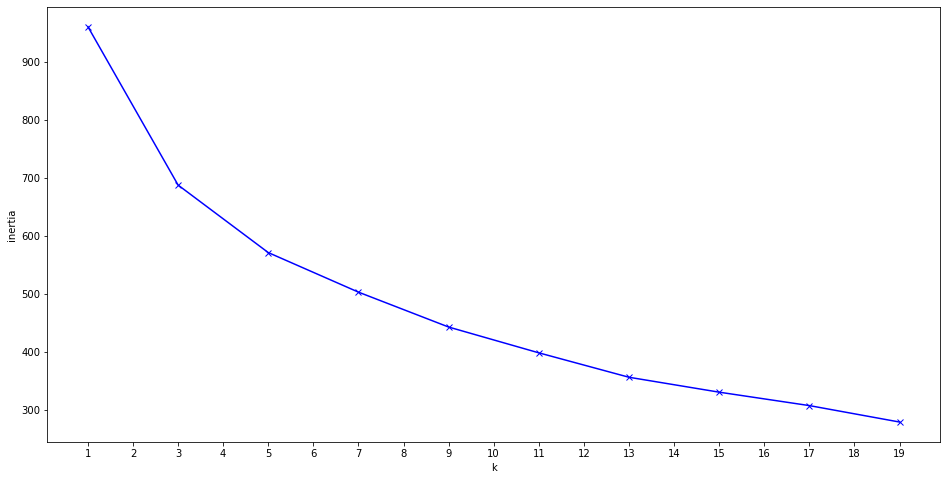

In [61]:
K = range(1, 20,2)

inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

### k = 9

In [62]:
kmeans = KMeans(n_clusters=9, random_state=42)
kmeans.fit(X_prep)

KMeans(n_clusters=9, random_state=42)

In [63]:
clusters = kmeans.predict(X_prep)
clusters

array([1, 2, 2, 1, 7, 0, 7, 2, 1, 8, 1, 1, 1, 0, 4, 0, 4, 1, 1, 1, 5, 5,
       2, 4, 7, 1, 7, 4, 4, 3, 2, 3, 2, 8, 1, 1, 1, 1, 3, 3, 5, 5, 1, 2,
       7, 0, 5, 1, 0, 0, 2, 5, 2, 8, 6, 7, 1, 6, 3, 3, 3, 2, 5, 2, 1, 1,
       2, 7, 5, 5, 7, 1, 0, 1, 2, 1, 1, 4, 1, 1, 0, 4, 1, 1, 5, 5, 7, 2,
       0, 4, 4, 1, 0, 0, 0, 4])

In [65]:
pd.Series(clusters).value_counts().sort_index()

0    12
1    28
2    14
3     7
4    10
5    11
6     2
7     9
8     3
dtype: int64

In [64]:
kmeans.inertia_
# k 3 = inertia 687.5298714303228

434.7201987449001

#### Silhouette Score

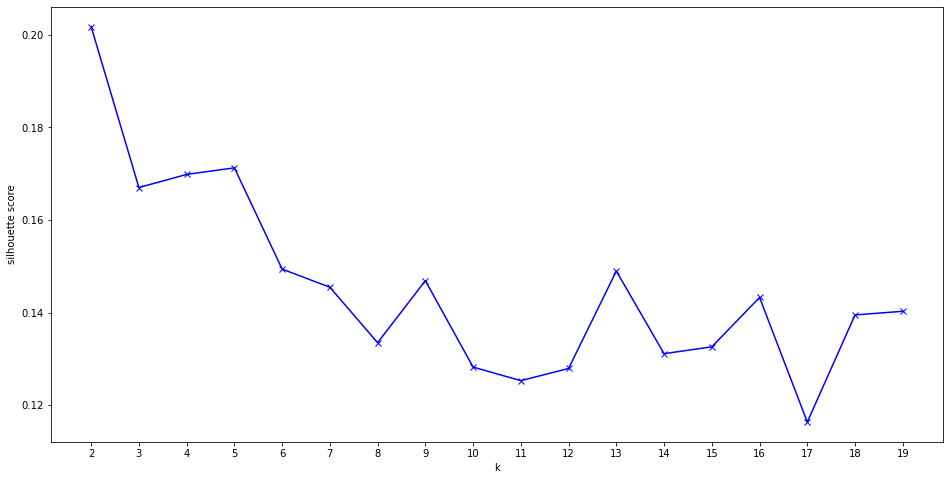

In [66]:
from sklearn.metrics import silhouette_score
K = range(2, 20)

silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_prep)
    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()